In [ ]:
# default_exp pipeline

# Module pipeline

> Pipeline for preprocessing diffusion weighted images (DWI) in a valid BIDS directory.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#exporti
import os, sys
import bids

bids.config.set_option("extension_initial_dot", True)

from shutil import which
from nipype.pipeline import Workflow

import pipetography.core as ppt
import pipetography.nodes as nodes

## Preprocessing `pipeline` module:

A class containing `core` functionalities wrapped in a `Nipype` workflow, assuming your input data is in valid BIDS format. This pipeline will follow the [DESIGNER](http://www.sciencedirect.com/science/article/pii/S1053811918306827) protocol and align your T1 & DWI to MNI template space (ACPC HCP procedure), perform all denoising & artifact removal steps, and correct the DWI gradients accordingly.

In [ ]:
#export
class pipeline:
    """
    Create a `Nipype` workflow, collects the layout of a BIDS directory, and branches the workflow into sub-graphs that can be ran in parallel per subject-session combination
    Inputs:
        - BIDS_dir (str): Path to BIDS dataset.
        - ext (str): Extension of your BIDS image files. Default is set to "nii.gz"
        - rpe_design (str): Reverse phase encoding design for your DWI acquisition. Also supports '-rpe_all', default is "-rpe_none"
        - regrid (bool): Whether  to resample DWI to  1mm MNI template, defaults to True.
        - mrtrix_nthreads (int): Number of threads for mrtrix3 algorithm. If zero, the number of available CPUs will be used. Default is 0.
        - skip_tuples (tuple): A combination of [('subject #', 'session #')] tuples that you'd want the workflow to skip, example: [('01', '03')] will skip sub-01/ses-03.
    """

    def __init__(
        self,
        BIDS_dir,
        ext="nii.gz",
        rpe_design="-rpe_none",
        regrid=True,
        mrtrix_nthreads=0,
        skip_tuples=[()],
    ):
        self.bids_dir = BIDS_dir
        self.rpe_design = rpe_design
        self.regrid = regrid
        self.mrtrix_nthreads = mrtrix_nthreads
        self.ext = ext
        self.excludes = skip_tuples
        self.MNI_template = os.path.expandvars(
            "$FSLDIR/data/standard/MNI152_T1_1mm.nii.gz"
        )
        # Create derivatives folder if it doesn't exist:
        if not os.path.exists(os.path.join(BIDS_dir, "derivatives")):
            print(
                "No derivatives folder found in BIDS dataset folder, creating it at {}".format(
                    os.path.join(BIDS_dir, "derivatives")
                )
            )
            os.makedirs(os.path.join(BIDS_dir, "derivatives"))
        elif os.path.exists(os.path.join(BIDS_dir, "derivatives")):
            print(
                "derivatives folder found at {}".format(
                    os.path.join(BIDS_dir, "derivatives")
                )
            )
        # Generate BIDS Layout, and create subject ID list:
        self.sub_list, self.ses_list, self.layout = ppt.get_subs(self.bids_dir)
        # string templates for images: the templates will depend on rpe_design:
        #  - rpe_none: anat_file, dwi_file, b_files
        #  - rpe_all/rpe_pair: anat_file, dwi_file, rdwi_file, b_files, rb_files
        if rpe_design == "-rpe_none":
            self.anat_file = os.path.join(
                "sub-{subject_id}",
                "ses-{session_id}",
                "anat",
                "sub-{subject_id}_ses-{session_id}_T1w." + ext,
            )
            self.dwi_file = os.path.join(
                "sub-{subject_id}",
                "ses-{session_id}",
                "dwi",
                "sub-{subject_id}_ses-{session_id}_dwi." + ext,
            )
            self.b_files = os.path.join(
                "sub-{subject_id}",
                "ses-{session_id}",
                "dwi",
                "sub-{subject_id}_ses-{session_id}_dwi.bv*",
            )
        elif rpe_design == "-rpe_all":
            # if all directions were acquired twice, with reverse phase encoding directions.
            self.anat_file = os.path.join(
                "sub-{subject_id}",
                "ses-{session_id}",
                "anat",
                "sub-{subject_id}_ses-{session_id}_T1w." + ext,
            )
            self.dwi_file = os.path.join(
                "sub-{subject_id}",
                "ses-{session_id}",
                "dwi",
                "sub-{subject_id}_ses-{session_id}_ap_dwi." + ext,
            )
            self.b_files = os.path.join(
                "sub-{subject_id}",
                "ses-{session_id}",
                "dwi",
                "sub-{subject_id}_ses-{session_id}_ap_dwi.bv*",
            )
            self.rdwi_file = os.path.join(
                "sub-{subject_id}",
                "ses-{session_id}",
                "dwi",
                "sub-{subject_id}_ses-{session_id}_pa_dwi." + ext,
            )
            self.rb_files = os.path.join(
                "sub-{subject_id}",
                "ses-{session_id}",
                "dwi",
                "sub-{subject_id}_ses-{session_id}_pa_dwi.bv*",
            )

    def create_nodes(self):
        if self.rpe_design == "-rpe_none":
            self.sub_template = {
                "anat": self.anat_file,
                "dwi": self.dwi_file,
                "b_files": self.b_files,
            }
        elif self.rpe_design == "-rpe_all":
            self.sub_template = {
                "anat": self.anat_file,
                "dwi": self.dwi_file,
                "bfiles": self.b_files,
                "rdwi": self.rdwi_file,
                "rbfiles": self.rb_files,
            }
        if self.regrid:
            resol = "1mm"
        else:
            resol = "orig"
        self.PreProcNodes = nodes.PreProcNodes(
            bids_dir=self.bids_dir,
            bids_path_template=self.sub_template,
            bids_ext=self.ext,
            rpe_design=self.rpe_design,
            img_resol=resol,
            mrtrix_nthreads=self.mrtrix_nthreads,
            sub_list=self.sub_list,
            ses_list=self.ses_list,
            exclude_list=self.excludes,
        )
        self.ACPCNodes = nodes.ACPCNodes(MNI_template=self.MNI_template)
        self.workflow = None

    def check_environment(self):
        """
        Check your computing environment for FSL environment variables `FSLOUTPUTTYPE` and `FSLDIR`
        Check if ANTs PATH is included in your environment
        Check if mrtrix3 is in your PATH
        Check your freesurfer envrionment variable
        Looks for matlab compiler run time in freesurfer directory: https://surfer.nmr.mgh.harvard.edu/fswiki/MatlabRuntime
        """
        assert "FSLOUTPUTTYPE" in os.environ
        assert "FSLDIR" in os.environ
        if "FSLOUTPUTTYPE" in os.environ:
            print("FSLOUTPUTTYPE is valid")
        else:
            sys.exit("FSLOUTPUTTYPE is not defined, make sure FSL is configured!")

        if "FSLDIR" in os.environ:
            print("FSLDIR is valid")
        else:
            sys.exit("FSLOUTPUTTYPE is not defined, make sure FSL is configured!")
        # ANTS:
        assert "ANTSPATH" in os.environ
        print("ANTS is valid")
        # mrtrix:
        assert which("dwifslpreproc") is not None
        print("mrtrix3 is valid")
        # freesurfer:
        assert "FREESURFER_HOME" in os.environ
        print("Freesurfer path found")
        # matlab compiler run time
        assert os.path.isdir(os.path.expandvars("$FREESURFER_HOME/MCRv80"))
        print("Matlab Compiler Runtime 2012 version in Freesurfer Path found. (MCRv80)")
        return None

    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
    # Connect the nodes we defined above into a workflow:
    def connect_nodes(
        self, rpe_design, recon=True, regrid=True, wf_name="pipetography"
    ):
        """
        Connect nodes one by one and create Nipype workflow
        Input: wfname (str): name your workflow, default is pipetography
        """
        # a workflow that will be filled in with connections:
        self.workflow = Workflow(
            name=wf_name,
            base_dir=os.path.join(self.bids_dir, "derivatives"),
        )
        # connections:
        self.workflow.connect(
            [
                (
                    self.PreProcNodes.subject_source,
                    self.PreProcNodes.select_files,
                    [("subject_id", "subject_id"), ("session_id", "session_id")],
                ),
                (
                    self.PreProcNodes.select_files,
                    self.ACPCNodes.reduceFOV,
                    [("anat", "in_file")],
                ),
                (
                    self.PreProcNodes.select_files,
                    self.ACPCNodes.ACPC_warp,
                    [("anat", "in_file")],
                ),
                (
                    self.ACPCNodes.reduceFOV,
                    self.ACPCNodes.xfminverse,
                    [("out_transform", "in_file")],
                ),
                (
                    self.ACPCNodes.xfminverse,
                    self.ACPCNodes.concatxfm,
                    [("out_file", "in_file")],
                ),
                (
                    self.ACPCNodes.reduceFOV,
                    self.ACPCNodes.flirt,
                    [("out_roi", "in_file")],
                ),
                (
                    self.ACPCNodes.flirt,
                    self.ACPCNodes.concatxfm,
                    [("out_matrix_file", "in_file2")],
                ),
                (
                    self.ACPCNodes.concatxfm,
                    self.ACPCNodes.alignxfm,
                    [("out_file", "in_file")],
                ),
                (
                    self.ACPCNodes.alignxfm,
                    self.ACPCNodes.ACPC_warp,
                    [("out_file", "premat")],
                ),
                (
                    self.ACPCNodes.ACPC_warp,
                    self.PreProcNodes.datasink,
                    [("out_file", "preprocessed.@t1_acpc_aligned")],
                ),
                ## Adding WM mask extraction to replace original recon all section
                (
                    self.ACPCNodes.ACPC_warp,
                    self.ACPCNodes.gen_5tt,
                    [("out_file", "in_file")],
                ),
                (
                    self.ACPCNodes.gen_5tt,
                    self.ACPCNodes.convert2wm,
                    [("out_file", "in_file")],
                ),
                (
                    self.ACPCNodes.gen_5tt,
                    self.ACPCNodes.gmwmi,
                    [("out_file", "in_file")],
                ),
                (
                    self.ACPCNodes.gmwmi,
                    self.ACPCNodes.binarize_gmwmi,
                    [("out_file", "in_file")],
                ),
                (
                    self.ACPCNodes.gen_5tt,
                    self.PreProcNodes.datasink,
                    [("out_file", "preprocessed.@mr5tt")],
                ),
                (
                    self.ACPCNodes.binarize_gmwmi,
                    self.PreProcNodes.datasink,
                    [("out_file", "preprocessed.@gmwmi")],
                ),
                (
                    self.ACPCNodes.convert2wm,
                    self.PreProcNodes.datasink,
                    [("out_file", "preprocessed.@wm")],
                ),
                ## WM Mask extraction section
                (
                    self.ACPCNodes.ACPC_warp,
                    self.ACPCNodes.t1_bet,
                    [("out_file", "in_file")],
                ),
                (
                    self.ACPCNodes.ACPC_warp,
                    self.ACPCNodes.epi_reg,
                    [("out_file", "t1_head")],
                ),
                (
                    self.ACPCNodes.t1_bet,
                    self.ACPCNodes.epi_reg,
                    [("out_file", "t1_brain")],
                ),
                (
                    self.PreProcNodes.sub_apply_mask,
                    self.ACPCNodes.epi_reg,
                    [("out_file", "epi")],
                ),
                (
                    self.ACPCNodes.epi_reg,
                    self.ACPCNodes.acpc_xfm,
                    [("epi2str_mat", "flirt_xfm")],
                ),
                (
                    self.PreProcNodes.sub_apply_mask,
                    self.ACPCNodes.acpc_xfm,
                    [("out_file", "flirt_in")],
                ),
                (
                    self.ACPCNodes.t1_bet,
                    self.ACPCNodes.acpc_xfm,
                    [("out_file", "flirt_ref")],
                ),
                (
                    self.ACPCNodes.acpc_xfm,
                    self.ACPCNodes.apply_xfm,
                    [("out_file", "linear_xfm")],
                ),
                (
                    self.PreProcNodes.norm_intensity,
                    self.ACPCNodes.apply_xfm,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.select_files,
                    self.PreProcNodes.get_metadata,
                    [("dwi", "path")],
                ),
                (
                    self.PreProcNodes.get_metadata,
                    self.PreProcNodes.fslpreproc,
                    [("ReadoutTime", "RO_time"), ("PE_DIR", "pe_dir")],
                ),
                (
                    self.PreProcNodes.createMask,
                    self.PreProcNodes.GradCheck,
                    [("out_file", "mask_file")],
                ),
                (
                    self.PreProcNodes.GradCheck,
                    self.PreProcNodes.NewGradMR,
                    [("out_bfile", "grad_file")],
                ),
                (
                    self.PreProcNodes.NewGradMR,
                    self.PreProcNodes.denoise,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.denoise,
                    self.PreProcNodes.degibbs,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.degibbs,
                    self.PreProcNodes.fslpreproc,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.GradCheck,
                    self.PreProcNodes.fslpreproc,
                    [("out_bfile", "grad_file")],
                ),
                (
                    self.PreProcNodes.fslpreproc,
                    self.PreProcNodes.GradUpdate,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.fslpreproc,
                    self.PreProcNodes.ModGrad,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.GradUpdate,
                    self.PreProcNodes.ModGrad,
                    [("out_bfile", "grad_file")],
                ),
                (
                    self.PreProcNodes.ModGrad,
                    self.PreProcNodes.UpdateMif,
                    [("out_bfile", "grad_file")],
                ),
                (
                    self.PreProcNodes.fslpreproc,
                    self.PreProcNodes.UpdateMif,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.UpdateMif,
                    self.PreProcNodes.NewMask,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.ModGrad,
                    self.PreProcNodes.NewMask,
                    [("out_bfile", "grad_file")],
                ),
                (
                    self.PreProcNodes.UpdateMif,
                    self.PreProcNodes.biascorrect,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.ModGrad,
                    self.PreProcNodes.biascorrect,
                    [("out_bfile", "grad_file")],
                ),
                (
                    self.PreProcNodes.NewMask,
                    self.PreProcNodes.biascorrect,
                    [("out_file", "in_mask")],
                ),
                (
                    self.PreProcNodes.biascorrect,
                    self.PreProcNodes.grad_info,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.ModGrad,
                    self.PreProcNodes.grad_info,
                    [("out_bfile", "grad_file")],
                ),
                (
                    self.PreProcNodes.denoise,
                    self.PreProcNodes.low_noise_map,
                    [("noise", "isfinite")],
                ),
                (
                    self.PreProcNodes.denoise,
                    self.PreProcNodes.low_noise_map,
                    [("noise", "cond_if")],
                ),
                (
                    self.PreProcNodes.low_noise_map,
                    self.PreProcNodes.rician_noise,
                    [("out_file", "lownoisemap")],
                ),
                (
                    self.PreProcNodes.biascorrect,
                    self.PreProcNodes.rician_noise,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.rician_noise,
                    self.PreProcNodes.check_rician,
                    [("out_file", "isfinite")],
                ),
                (
                    self.PreProcNodes.rician_noise,
                    self.PreProcNodes.check_rician,
                    [("out_file", "cond_if")],
                ),
                (
                    self.PreProcNodes.check_rician,
                    self.PreProcNodes.convert_rician,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.grad_info,
                    self.PreProcNodes.convert_rician,
                    [("out_bfile", "grad_file")],
                ),
                (
                    self.PreProcNodes.convert_rician,
                    self.PreProcNodes.dwi_mask,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.dwi_mask,
                    self.PreProcNodes.fit_tensor,
                    [("out_file", "in_mask")],
                ),
                (
                    self.PreProcNodes.convert_rician,
                    self.PreProcNodes.fit_tensor,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.fit_tensor,
                    self.PreProcNodes.tensor_FA,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.tensor_FA,
                    self.PreProcNodes.wm_mask,
                    [("out_fa", "in_file")],
                ),
                (
                    self.PreProcNodes.wm_mask,
                    self.PreProcNodes.norm_intensity,
                    [("out_file", "mask_file")],
                ),
                (
                    self.PreProcNodes.convert_rician,
                    self.PreProcNodes.norm_intensity,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.norm_intensity,
                    self.PreProcNodes.sub_b0extract,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.sub_b0extract,
                    self.PreProcNodes.sub_b0mean,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.norm_intensity,
                    self.PreProcNodes.sub_b0mask,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.sub_b0mask,
                    self.PreProcNodes.sub_convert_mask,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.sub_b0mean,
                    self.PreProcNodes.sub_convert_dwi,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.sub_convert_dwi,
                    self.PreProcNodes.sub_apply_mask,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.sub_convert_mask,
                    self.PreProcNodes.sub_apply_mask,
                    [("out_file", "mask_file")],
                ),
                (
                    self.PreProcNodes.mni_b0extract,
                    self.PreProcNodes.mni_b0mean,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.mni_b0mask,
                    self.PreProcNodes.mni_convert_mask,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.mni_b0mean,
                    self.PreProcNodes.mni_convert_dwi,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.mni_convert_mask,
                    self.PreProcNodes.mni_apply_mask,
                    [("out_file", "mask_file")],
                ),
                (
                    self.PreProcNodes.mni_convert_dwi,
                    self.PreProcNodes.mni_apply_mask,
                    [("out_file", "in_file")],
                ),
                (
                    self.PreProcNodes.mni_apply_mask,
                    self.PreProcNodes.datasink,
                    [("out_file", "preprocessed.@dwi_brain")],
                ),
                (
                    self.PreProcNodes.mni_convert_mask,
                    self.PreProcNodes.datasink,
                    [("out_file", "preprocessed.@dwi_b0_brainmask")],
                ),
                (
                    self.PreProcNodes.mni_convert_dwi,
                    self.PreProcNodes.datasink,
                    [("out_file", "preprocessed.@dwi_b0_meanvolume")],
                ),
                (
                    self.PreProcNodes.mni_dwi,
                    self.PreProcNodes.datasink,
                    [("out_file", "preprocessed.@dwi")],
                ),
                (
                    self.PreProcNodes.mni_dwi,
                    self.PreProcNodes.datasink,
                    [("out_bfile", "preprocessed.@b")],
                ),
                (
                    self.PreProcNodes.mni_dwi,
                    self.PreProcNodes.datasink,
                    [("out_fslbvec", "preprocessed.@fsl_bvec")],
                ),
                (
                    self.PreProcNodes.mni_dwi,
                    self.PreProcNodes.datasink,
                    [("out_fslbval", "preprocessed.@fsl_bval")],
                ),
                (
                    self.PreProcNodes.mni_dwi,
                    self.PreProcNodes.datasink,
                    [("out_json", "preprocessed.@json")],
                ),
            ]
        )

        if rpe_design == "-rpe_none":
            self.workflow.connect(
                [
                    (
                        self.PreProcNodes.select_files,
                        self.PreProcNodes.mrconvert,
                        [("dwi", "in_file")],
                    ),
                    (
                        self.PreProcNodes.select_files,
                        self.PreProcNodes.sub_grad_files,
                        [("dwi", "sub_dwi")],
                    ),
                    (
                        self.PreProcNodes.sub_grad_files,
                        self.PreProcNodes.mrconvert,
                        [("fslgrad", "grad_fsl")],
                    ),
                    (
                        self.PreProcNodes.mrconvert,
                        self.PreProcNodes.createMask,
                        [("out_file", "in_file")],
                    ),
                    (
                        self.PreProcNodes.mrconvert,
                        self.PreProcNodes.GradCheck,
                        [("out_file", "in_file")],
                    ),
                    (
                        self.PreProcNodes.mrconvert,
                        self.PreProcNodes.GradCheck,
                        [("out_bfile", "grad_file")],
                    ),
                    (
                        self.PreProcNodes.mrconvert,
                        self.PreProcNodes.NewGradMR,
                        [("out_file", "in_file")],
                    ),
                    (
                        self.PreProcNodes.fslpreproc,
                        self.PreProcNodes.GradUpdate,
                        [("out_bfile", "grad_file")],
                    ),
                ]
            )
        elif rpe_design == "-rpe_all":
            self.workflow.connect(
                [
                    (
                        self.PreProcNodes.select_files,
                        self.PreProcNodes.sub_grad_files1,
                        [("dwi", "sub_dwi")],
                    ),
                    (
                        self.PreProcNodes.select_files,
                        self.PreProcNodes.sub_grad_files2,
                        [("rdwi", "sub_dwi")],
                    ),
                    (
                        self.PreProcNodes.select_files,
                        self.PreProcNodes.mrconvert1,
                        [("dwi", "in_file")],
                    ),
                    (
                        self.PreProcNodes.select_files,
                        self.PreProcNodes.mrconvert2,
                        [("rdwi", "in_file")],
                    ),
                    (
                        self.PreProcNodes.sub_grad_files1,
                        self.PreProcNodes.mrconvert1,
                        [("fslgrad", "grad_fsl")],
                    ),
                    (
                        self.PreProcNodes.sub_grad_files2,
                        self.PreProcNodes.mrconvert2,
                        [("fslgrad", "grad_fsl")],
                    ),
                    (
                        self.PreProcNodes.mrconvert1,
                        self.PreProcNodes.mrconcat,
                        [("out_file", "image1")],
                    ),
                    (
                        self.PreProcNodes.mrconvert2,
                        self.PreProcNodes.mrconcat,
                        [("out_file", "image2")],
                    ),
                    (
                        self.PreProcNodes.mrconvert1,
                        self.PreProcNodes.gradcat,
                        [("out_bfile", "grad1")],
                    ),
                    (
                        self.PreProcNodes.mrconvert2,
                        self.PreProcNodes.gradcat,
                        [("out_bfile", "grad2")],
                    ),
                    (
                        self.PreProcNodes.mrconcat,
                        self.PreProcNodes.createMask,
                        [("out_file", "in_file")],
                    ),
                    (
                        self.PreProcNodes.mrconcat,
                        self.PreProcNodes.GradCheck,
                        [("out_file", "in_file")],
                    ),
                    (
                        self.PreProcNodes.gradcat,
                        self.PreProcNodes.GradCheck,
                        [("out_file", "grad_file")],
                    ),
                    (
                        self.PreProcNodes.mrconcat,
                        self.PreProcNodes.NewGradMR,
                        [("out_file", "in_file")],
                    ),
                    (
                        self.PreProcNodes.mrconvert1,
                        self.PreProcNodes.GradUpdate,
                        [("out_bfile", "grad_file")],
                    ),
                ]
            )
        if regrid == True:
            self.workflow.connect(
                [
                    (
                        self.ACPCNodes.apply_xfm,
                        self.ACPCNodes.regrid,
                        [("out_file", "in_file")],
                    ),
                    (
                        self.ACPCNodes.regrid,
                        self.PreProcNodes.datasink,
                        [("out_file", "preprocessed.@dwi_acpc_aligned_1mm")],
                    ),
                    (
                        self.ACPCNodes.regrid,
                        self.PreProcNodes.mni_b0extract,
                        [("out_file", "in_file")],
                    ),
                    (
                        self.ACPCNodes.regrid,
                        self.PreProcNodes.mni_b0mask,
                        [("out_file", "in_file")],
                    ),
                    (
                        self.ACPCNodes.regrid,
                        self.PreProcNodes.mni_dwi,
                        [("out_file", "in_file")],
                    ),
                ]
            )
        elif regrid == False:
            self.workflow.connect(
                [
                    (
                        self.ACPCNodes.apply_xfm,
                        self.PreProcNodes.mni_b0extract,
                        [("out_file", "in_file")],
                    ),
                    (
                        self.ACPCNodes.apply_xfm,
                        self.PreProcNodes.mni_b0mask,
                        [("out_file", "in_file")],
                    ),
                    (
                        self.ACPCNodes.apply_xfm,
                        self.PreProcNodes.mni_dwi,
                        [("out_file", "in_file")],
                    ),
                ]
            )
        self.workflow.config["execution"] = {
            "use_relative_paths": "True",
            "hash_method": "content",
            "stop_on_first_crash": "True",
        }

    def draw_pipeline(self, graph_type="orig"):
        """
        Writes a `.png` image visualizing the workflow.
        Args:
            graph_type (str): Select from `orig`, `flat`, `hierarchical`, `colored`, or `exec`. See Nipype documentation for details. Defaults to orig.
        """
        self.workflow.write_graph(
            graph2use=graph_type,
            dotfilename=os.path.join(
                self.bids_dir, "derivatives", "pipetography", "graph", "preprocessing.dot"
            ),
        )

    def run_pipeline(self, parallel=None):
        if type(parallel) == int:
            print("Running workflow with {} parallel processes".format(parallel))
            self.workflow.run("MultiProc", plugin_args={"n_procs": parallel})
        elif parallel is None:
            print("Parallel processing is not enabled, running workflow serially.")
            self.workflow.run()

In [ ]:
#hide
#test

wf_1 = pipeline(BIDS_dir="testing/BIDS_dir")
wf_1.create_nodes()
wf_1.connect_nodes(rpe_design="-rpe_none")
wf_1.draw_pipeline(graph_type="flat")
assert wf_1.bids_dir == "testing/BIDS_dir"
assert wf_1.rpe_design == "-rpe_none"
assert wf_1.regrid == True
assert wf_1.ext == "nii.gz"
assert wf_1.MNI_template == os.path.expandvars(
    "$FSLDIR/data/standard/MNI152_T1_1mm.nii.gz"
)
assert wf_1.layout.get_subjects() == wf_1.sub_list
# assert drawn workflow is present as png and dot:
assert os.path.exists("./testing/BIDS_dir/derivatives/pipetography/graph/preprocessing.dot")
assert os.path.exists("./testing/BIDS_dir/derivatives/pipetography/graph/preprocessing.png")

wf_2 = pipeline(BIDS_dir="testing/BIDS_dir", ext="nii", rpe_design="-rpe_all")
wf_2.create_nodes()
wf_2.connect_nodes(rpe_design="-rpe_all")
assert wf_2.rpe_design == "-rpe_all"
assert wf_2.ext == "nii"

# assert output folder is complaint with BIDS, a derivatives folder in root of BIDS dataset directory
assert os.path.abspath(
    wf_1.PreProcNodes.datasink.inputs.base_directory
) == os.path.abspath(os.path.join("./testing/BIDS_dir", "derivatives", "pipetography"))

derivatives folder found at testing/BIDS_dir/derivatives
Creating layout of data directory, might take a while if there are a lot of subjects
Data sink (output folder) is set to testing/BIDS_dir/derivatives/pipetography
201217-23:04:06,245 nipype.workflow INFO:
	 Generated workflow graph: /Users/xxie/lab/pipetography/testing/BIDS_dir/derivatives/pipetography/graph/preprocessing.png (graph2use=flat, simple_form=True).
derivatives folder found at testing/BIDS_dir/derivatives
Creating layout of data directory, might take a while if there are a lot of subjects
Data sink (output folder) is set to testing/BIDS_dir/derivatives/pipetography


### Example:

Create a `pipeline`:

In [ ]:
#example
preproc_dwi = pipeline(BIDS_dir='/Users/xxie/sample_data/dwipreproc/BIDS_output/', 
                       rpe_design='-rpe_none', 
                       regrid=True, 
                       mrtrix_nthreads=12,
                       skip_tuples=[('01', '003')])

derivatives folder found at /Users/xxie/sample_data/dwipreproc/BIDS_output/derivatives
Creating layout of data directory, might take a while if there are a lot of subjects


Check if our environment is properly set-up:

In [ ]:
#example
preproc_dwi.check_environment()

FSLOUTPUTTYPE is valid
FSLDIR is valid
ANTS is valid
mrtrix3 is valid
Freesurfer path found
Matlab Compiler Runtime 2012 version in Freesurfer Path found. (MCRv80)


Take a look at what's in the `pipeline`:

In [ ]:
#example
preproc_dwi.__dict__

{'bids_dir': '/Users/xxie/sample_data/dwipreproc/BIDS_output/',
 'rpe_design': '-rpe_none',
 'regrid': True,
 'mrtrix_nthreads': 12,
 'ext': 'nii.gz',
 'excludes': [('01', '003')],
 'MNI_template': '/usr/local/fsl/data/standard/MNI152_T1_1mm.nii.gz',
 'sub_list': ['01'],
 'ses_list': ['002', '003'],
 'layout': BIDS Layout: ...le_data/dwipreproc/BIDS_output | Subjects: 1 | Sessions: 2 | Runs: 0,
 'anat_file': 'sub-{subject_id}/ses-{session_id}/anat/sub-{subject_id}_ses-{session_id}_T1w.nii.gz',
 'dwi_file': 'sub-{subject_id}/ses-{session_id}/dwi/sub-{subject_id}_ses-{session_id}_dwi.nii.gz',
 'b_files': 'sub-{subject_id}/ses-{session_id}/dwi/sub-{subject_id}_ses-{session_id}_dwi.bv*'}

We can tweak some things in the pipeline (this is totally not necessary if your BIDS dataset follows conventional naming), for example, to fit the subject file template strings to match our dataset naming scheme:

In [ ]:
#example
#if necessary, you can fit the file templates to match dataset naming conventions
#preproc_dwi.anat_file = 'sub-{subject_id}/ses-{session_id}/anat/sub-{subject_id}_ses-{session_id}_run-1_T1w.nii'
#preproc_dwi.dwi_file = 'sub-{subject_id}/ses-{session_id}/dwi/sub-{subject_id}_ses-{session_id}_run-1_dwi.nii'
#preproc_dwi.rdwi_file = 'sub-{subject_id}/ses-{session_id}/dwi/sub-{subject_id}_ses-{session_id}_run-2_dwi.nii'
#preproc_dwi.b_files = 'sub-{subject_id}/ses-{session_id}/dwi/sub-{subject_id}_ses-{session_id}_run-1_dwi.bv*'
#preproc_dwi.rb_files = 'sub-{subject_id}/ses-{session_id}/dwi/sub-{subject_id}_ses-{session_id}_run-2_dwi.bv*'

# Initiate our nodes:
preproc_dwi.create_nodes()

preproc_dwi.__dict__

Data sink (output folder) is set to /Users/xxie/sample_data/dwipreproc/BIDS_output/derivatives/pipetography


{'bids_dir': '/Users/xxie/sample_data/dwipreproc/BIDS_output/',
 'rpe_design': '-rpe_none',
 'regrid': True,
 'mrtrix_nthreads': 12,
 'ext': 'nii.gz',
 'excludes': [('01', '003')],
 'MNI_template': '/usr/local/fsl/data/standard/MNI152_T1_1mm.nii.gz',
 'sub_list': ['01'],
 'ses_list': ['002', '003'],
 'layout': BIDS Layout: ...le_data/dwipreproc/BIDS_output | Subjects: 1 | Sessions: 2 | Runs: 0,
 'anat_file': 'sub-{subject_id}/ses-{session_id}/anat/sub-{subject_id}_ses-{session_id}_T1w.nii.gz',
 'dwi_file': 'sub-{subject_id}/ses-{session_id}/dwi/sub-{subject_id}_ses-{session_id}_dwi.nii.gz',
 'b_files': 'sub-{subject_id}/ses-{session_id}/dwi/sub-{subject_id}_ses-{session_id}_dwi.bv*',
 'sub_template': {'anat': 'sub-{subject_id}/ses-{session_id}/anat/sub-{subject_id}_ses-{session_id}_T1w.nii.gz',
  'dwi': 'sub-{subject_id}/ses-{session_id}/dwi/sub-{subject_id}_ses-{session_id}_dwi.nii.gz',
  'b_files': 'sub-{subject_id}/ses-{session_id}/dwi/sub-{subject_id}_ses-{session_id}_dwi.bv*'},
 '

We can set up preprocessing pipeline with default parameters, this will connect all workflow nodes with default input names and parameter values:

In [ ]:
#example
#usage
preproc_dwi.connect_nodes(rpe_design='-rpe_none')

All the default settings may not be optimal for your dataset, run the processing for a test image and see the intermediate results and then tweak the available inputs to improve the output image quality.

Now that our pre-processing Nodes are properly setup, we can visualize our workflow:

In [ ]:
#example
#preproc_dwi.connect_nodes(wf_name = 'pipetography')
preproc_dwi.draw_pipeline(graph_type='flat')

201217-23:04:18,18 nipype.workflow INFO:
	 Generated workflow graph: /Users/xxie/sample_data/dwipreproc/BIDS_output/derivatives/pipetography/graph/preprocessing.png (graph2use=flat, simple_form=True).


Let's take a look at the final workflow we created:

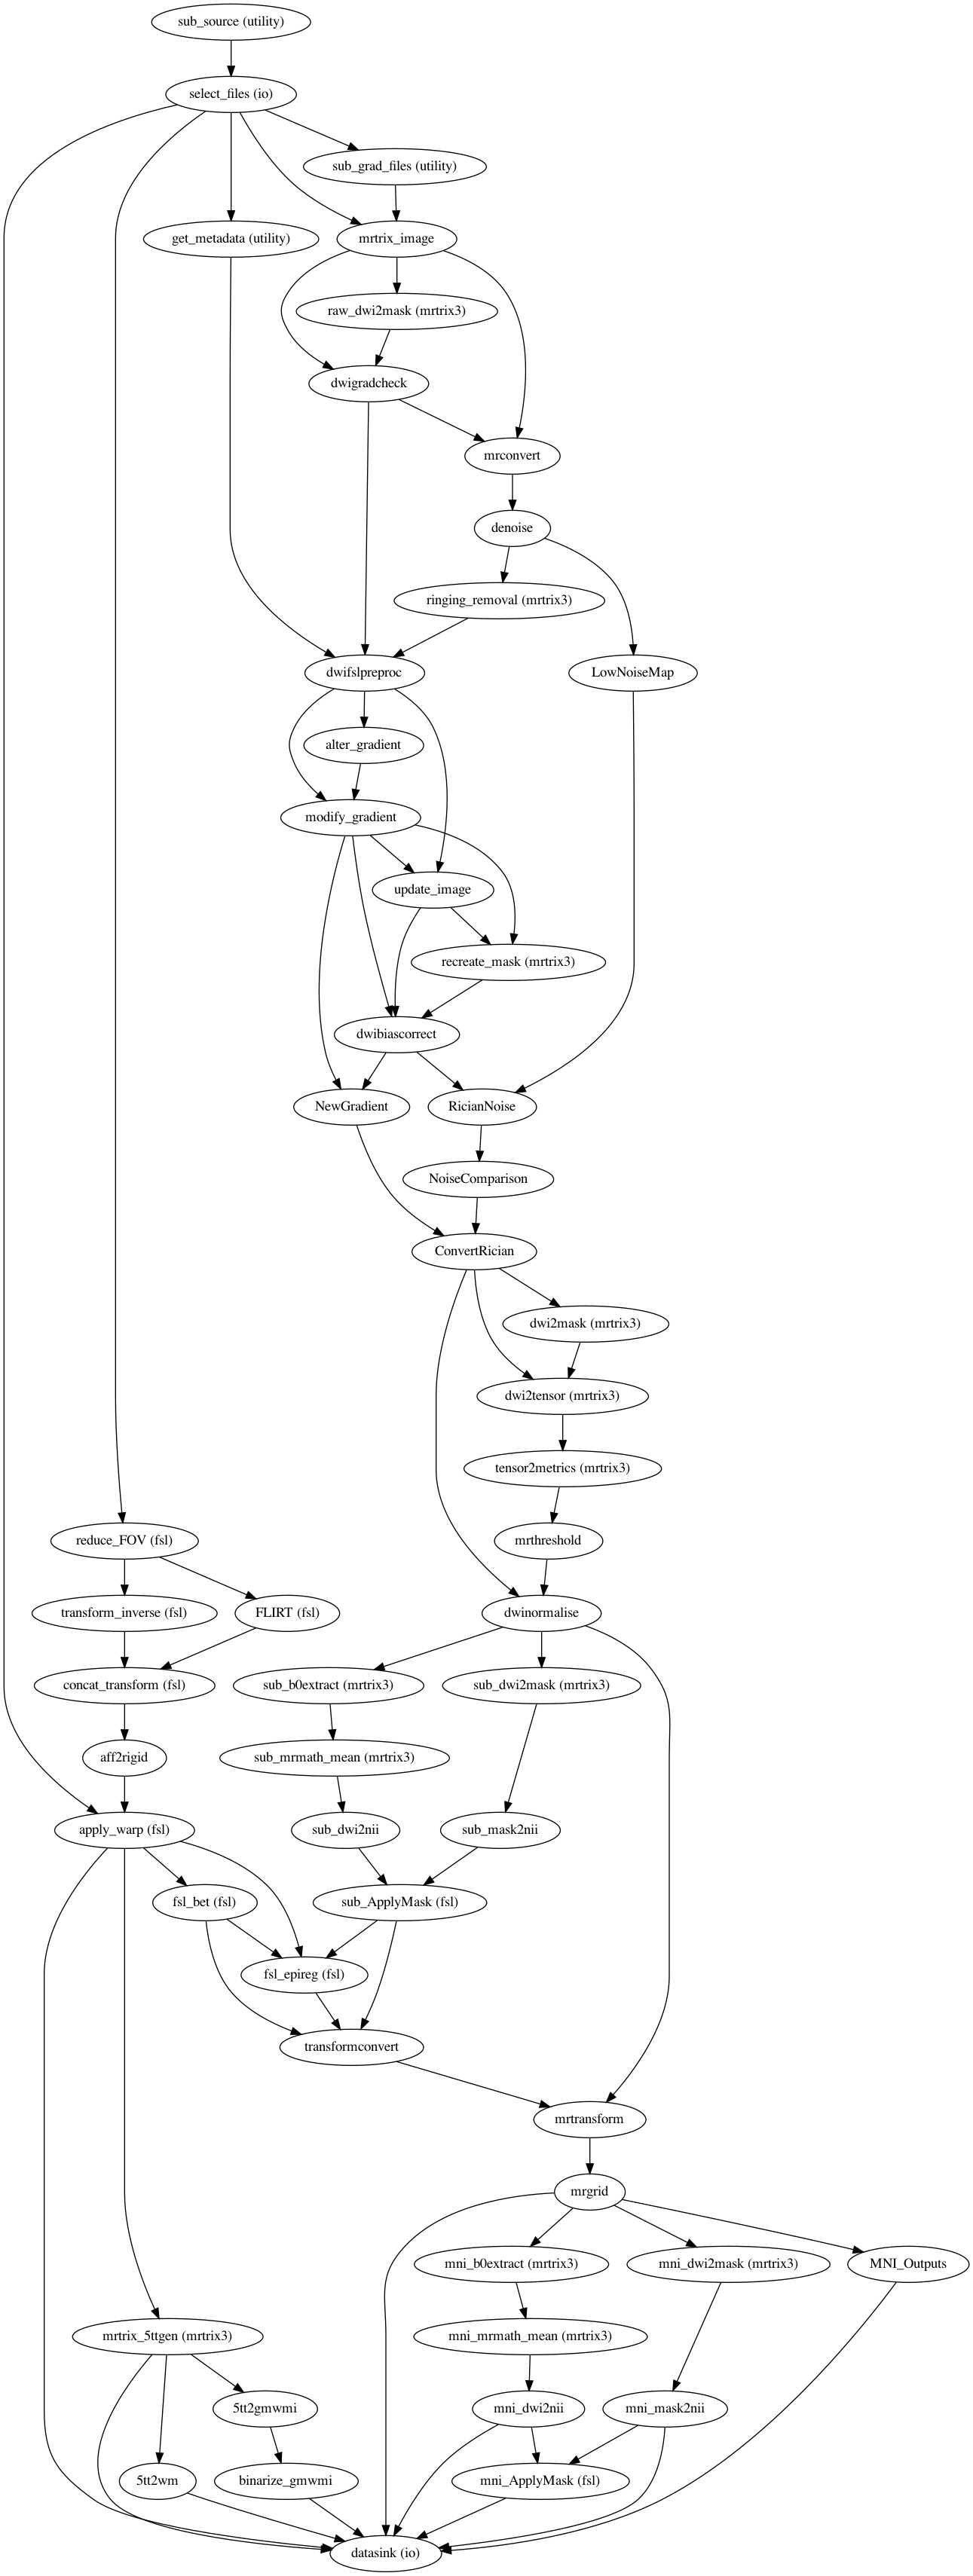

In [ ]:
#example
from IPython.display import Image
Image('/Users/xxie/sample_data/dwipreproc/BIDS_output/derivatives/pipetography/graph/preprocessing.png')

### Run pipeline:

Calling `run_pipeline` will prompt an user input for the number of parallel processes 

In [ ]:
#example
preproc_dwi.run_pipeline(parallel = 4)

Running workflow with 4 parallel processes
201217-23:04:26,779 nipype.workflow INFO:
	 Workflow pipetography settings: ['check', 'execution', 'logging', 'monitoring']
201217-23:04:26,825 nipype.workflow INFO:
	 Running in parallel.
201217-23:04:26,832 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.80/28.80, Free processors: 4/4.
201217-23:04:28,832 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 28.60/28.80, Free processors: 3/4.
                     Currently running:
                       * pipetography.select_files
201217-23:04:30,832 nipype.workflow INFO:
	 [Job 0] Completed (pipetography.select_files).
201217-23:04:30,834 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 28.80/28.80, Free processors: 4/4.
201217-23:04:32,833 nipype.workflow INFO:
	 [Job 1] Completed (pipetography.sub_grad_files).
201217-23:04:32,835 nipype.workflow INFO:
	 [MultiProc] Runni

## Outputs:

The datasink node will automatically create a derivatives folder in the BIDS directory folder if it doesn't find a derivatives folder. The `derivatives` directory will contain output images and gradient files that are realigned and resampled to MNI template:

In [ ]:
#example
!tree /Users/xxie/sample_data/dwipreproc/BIDS_output/derivatives/

/Users/xxie/sample_data/dwipreproc/BIDS_output/derivatives/
└── pipetography
    ├── graph
    │   ├── preprocessing.dot
    │   ├── preprocessing.png
    │   ├── preprocessing_detailed.dot
    │   └── preprocessing_detailed.png
    └── sub-01
        └── ses-002
            └── preprocessed
                ├── T1w_space-acpc.nii.gz
                ├── T1w_space-acpc_seg-5tt.mif
                ├── T1w_space-acpc_seg-gmwmi_mask.nii.gz
                ├── T1w_space-acpc_seg-wm_mask.nii.gz
                ├── dwi_space-acpc_res-1mm.b
                ├── dwi_space-acpc_res-1mm.bvals
                ├── dwi_space-acpc_res-1mm.bvecs
                ├── dwi_space-acpc_res-1mm.json
                ├── dwi_space-acpc_res-1mm.mif
                ├── dwi_space-acpc_res-1mm.nii.gz
                ├── dwi_space-acpc_res-1mm_b0mean.nii.gz
                ├── dwi_space-acpc_res-1mm_seg-brain.nii.gz
                └── dwi_space-acpc_res-1mm_seg-brain_mask.nii.gz

5 directories, 17 files
